# **STAT 301 Project Final Report: Predict the Number of Rings on the Shell of Abalone**

##### -- by *Jingyuan Liu (69763183), Pahul Brar (84892280), Geng Chen (51264893) and Shiyu Jiang (56479256)* from Group 11

## **Introduction:**

### Dataset: Abalone

In this project, we will use the “[Abalone](https://archive.ics.uci.edu/dataset/1/abalone)”[1] dataset found on [UCI Machine Learning Repository](https://archive.ics.uci.edu/). This dataset contains many physical features (measurements) of abalone with 4177 observations (rows) without any missing values. There are 9 columns, including 1 categorical variable and 8 numerical variables.

Variable information could be found on http://archive.ics.uci.edu/dataset/1/abalone.

### Inspiration and Background Information:

In this course, we have learned a lot about regression models and the associated experiment design methods. "The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- **a boring and time-consuming task**", but can some modern statistical models be used to help predict the the number of rings on the shell of abalone based on some of its physical measurements? 

### Justification for Certain Variables:
Since the age of abalone is inherently determined by the number of rings on their shell and is well justified, the response variable for this project is, in fact, `Rings`. In this analysis, we **initially** treat the number of rings (`Rings`) as a continuous response variable even though they are recorded as discrete counts, to meet the assumption of linear regression models. Since `Rings` is well ordered as 1, 2, 3, and so on, all the way to some large numbers, we consider that treating `Rings` as a continuous variable can be well justified even though it is not optimal.

### Question of Interest:
What is the most powerful predictive model that predicts the number of rings on the shell of abalone (`Rings`)? To be more specific, can we assume that the response variable `Rings` is continuous and fit the traditional linear regression model? Or is another mechanism, such as Poisson regression, more suitable for handling the discrete count response variable in predicting the number of rings (`Rings`)?

Scientific publications used for this study are included in the **References** section.

## **Methods and Results:**

### Exploratory Data Analysis (EDA):
The link to the GitHub repository of this project: https://github.com/ljy0401/STAT-301-Project-Group-11.git.

Load packages and read the data from web ([GitHub repository](https://raw.githubusercontent.com/ljy0401/STAT-301-Project-Group-11/main/abalone.csv)) into R.

In [20]:
# Run this cell before continuing
library(tidyverse)
library(GGally)
library(tidyr)
library(broom)
library(repr)
library(car)
library(tidymodels)
library(glmnet)
library(mltools)

In [2]:
url <- "https://raw.githubusercontent.com/ljy0401/STAT-301-Project-Group-11/main/abalone.csv"
abalone_data <- read_csv(url, col_name = FALSE)
head(abalone_data,3)

Rows: 4177 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1
dbl (8): X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


Table 1

The raw dataset only has default column names like `X1`, `X2`. Based on the variable information found on the [website](http://archive.ics.uci.edu/dataset/1/abalone), we can assign a more descriptive name for each column.

In [3]:
col_names <- c('Sex','Length','Diameter','Height','Whole_weight',
               'Shucked_weight','Viscera_weight','Shell_weight','Rings')
abalone_data <- setNames(abalone_data, col_names)
abalone_data <- abalone_data %>%
  mutate(Sex = case_when(Sex == 'I' ~ 'Infant', Sex == 'F' ~ 'Female', Sex == 'M' ~ 'Male'))
abalone_data$Sex <- as.factor(abalone_data$Sex)
head(abalone_data,3)

Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Male,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
Male,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
Female,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


Table 2

Obtain a summary table for each variable in this dataset using the `summary()` function.

In [4]:
summary(abalone_data)

     Sex           Length         Diameter          Height      
 Female:1307   Min.   :0.075   Min.   :0.0550   Min.   :0.0000  
 Infant:1342   1st Qu.:0.450   1st Qu.:0.3500   1st Qu.:0.1150  
 Male  :1528   Median :0.545   Median :0.4250   Median :0.1400  
               Mean   :0.524   Mean   :0.4079   Mean   :0.1395  
               3rd Qu.:0.615   3rd Qu.:0.4800   3rd Qu.:0.1650  
               Max.   :0.815   Max.   :0.6500   Max.   :1.1300  
  Whole_weight    Shucked_weight   Viscera_weight    Shell_weight   
 Min.   :0.0020   Min.   :0.0010   Min.   :0.0005   Min.   :0.0015  
 1st Qu.:0.4415   1st Qu.:0.1860   1st Qu.:0.0935   1st Qu.:0.1300  
 Median :0.7995   Median :0.3360   Median :0.1710   Median :0.2340  
 Mean   :0.8287   Mean   :0.3594   Mean   :0.1806   Mean   :0.2388  
 3rd Qu.:1.1530   3rd Qu.:0.5020   3rd Qu.:0.2530   3rd Qu.:0.3290  
 Max.   :2.8255   Max.   :1.4880   Max.   :0.7600   Max.   :1.0050  
     Rings       
 Min.   : 1.000  
 1st Qu.: 8.000  
 Median 

Table 3

The codes used to generate the pair plot is slow to execute (up to 1 minute on my device), and including this plot results in a larger size of the `.ipynb` file (up to 50 MB). So in order to save some computational time and storage memory when running this notebook, we ran the cell below once and took a screenshot of the pair plot, saving it as a `.PNG` image file and uploaded the image file to the project [GitHub repository](https://github.com/ljy0401/STAT-301-Project-Group-11.git). And then inserted the plot image in a markdown cell below using its [link](https://github.com/ljy0401/STAT-301-Project-Group-11/blob/main/pair%20plot.PNG?raw=true) on the [GitHub repository](https://github.com/ljy0401/STAT-301-Project-Group-11.git).

Feel free to uncomment the code cell below and generate the pair plot in real time to check the reproducibility of the plotting code. You may want to comment out that cell again and restart the kernel afterwards.

In [5]:
# options(repr.plot.width = 10, repr.plot.height = 8)
# abalone_data_pair_plots <- abalone_data %>%
#   ggpairs(progress = FALSE) +
#   theme(text = element_text(size = 10), plot.title = element_text(face = "bold"),
#         axis.title = element_text(face = "bold"))
# abalone_data_pair_plots

![eample](https://github.com/ljy0401/STAT-301-Project-Group-11/blob/main/pair%20plot.PNG?raw=true)

Figure 1 [link to the image of the pair plot](https://github.com/ljy0401/STAT-301-Project-Group-11/blob/main/pair%20plot.PNG?raw=true)

The line plots display the underlying empirical distribution of each numerical variable. The `Length` and `Diameter` variables are left-skewed while the rest seem to be right-skewed. But the distributions of all numerical variables appear to be unimodal. The bar chart shows that each level has relatively balanced number of observations. These indicate that all variables in the dataset are reasonable and there are no obvious outliers.

If we focus on the corresponding box plots and histograms on the pair plot, they show the distribution of each numerical variable for each level of the categorical variable `Sex`. They also suggest that the distribution of `Rings` for each level of `Sex` does not vary significantly.

The scatter plots in the last row are the ones between the response variable `Sex` and each numerical input variable. Fortunately, we observe that all numerical input variables have a positive relationship with the response variable `Rings`, and most of these relationships appear to be relatively linear.

The scatter plots between input variables and their corresponding correlation values remind us that some input variables are **highly correlated**. These scatter plots are indicators and a warning sign that we need to be extra cautious about multicollinearity.

#### In-depth Analysis of Multicollinearity (Part of EDA):
Create a correlation matrix of numerical input variables and visualize it:

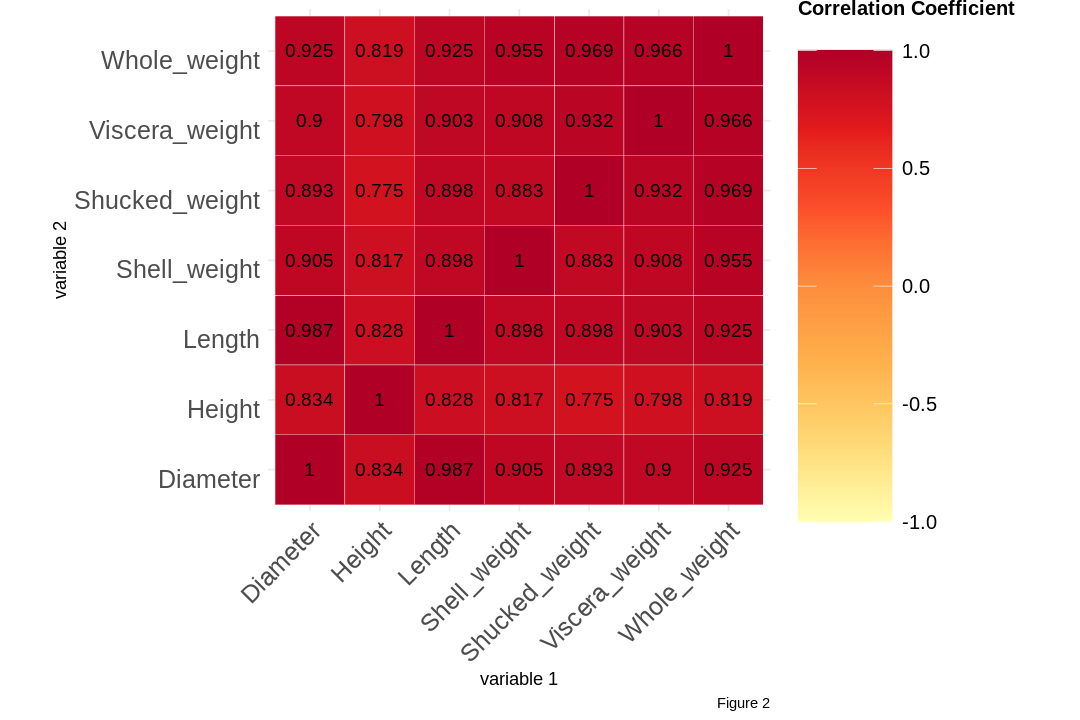

In [6]:
corr_matrix_abalone <- abalone_data %>%
  select(- c(Sex, Rings)) %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "correlation")

options(repr.plot.width = 9, repr.plot.height = 6)
plot_corr_matrix_abalone <- corr_matrix_abalone %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = correlation), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette = 'YlOrRd',
    direction = 1, limits = c(-1,1)
  ) +
  labs(x = "variable 1", y = "variable 2") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 15, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 15, hjust = 1
    ),
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 12),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  labs(caption="Figure 2")+
  geom_text(aes(var1, var2, label = round(correlation, 3)), color = "black", size = 4)
plot_corr_matrix_abalone

All input variables appear to be highly correlated with one another, with many of them having correlation values even exceeding 0.8. 

Now we can demonstrate the raw Variance Inflation Factor (VIF) of **numerical input variables**.

In [7]:
mlr_full_abalone_for_vif <- lm(Rings~.-Sex, data=abalone_data)
vif_mlr_full_abalone_for_vif <- round(vif(mlr_full_abalone_for_vif), 3)
vif_mlr_full_abalone_for_vif

Length       Diameter         Height   Whole_weight Shucked_weight 
        40.772         41.845          3.560        109.593         28.353 
Viscera_weight   Shell_weight 
        17.346         21.258

The result above shows that the VIFs of most input variables are extremely high (far larger than 1), which proves the existence of multicollinearity in the dataset.

### Methods & Plan:

In this project, we compare the performance of two predictive models that predict the number of rings (`Rings`) on the shell of abalone by evaluating their average Root Mean Square Error using cross validation on the training dataset. Subsequently, we pick the better model to perform prediction on the testing dataset and compute its corresponding metrics (RMSE) to evaluate its predictive performance. 

Initially, we treat the response variable `Rings` as continuous and fit a **traditional (Gaussian) linear regression model** with **Ridge algorithm**. Afterward, we want to assess whether treating `Rings` as a continuous variable is appropriate or not, so we fit a **Poisson regression model** that can better handle the data when the response variable is actually discrete counts, still using **Ridge algorithm**.

The choice of the **Ridge algorithm** for both models is motivated by the issue of multicollinearity in the dataset. Regularized methods, such as ridge algorithm, can better eliminate the existence of multicollinearity in the data by distributing the weight of highly-correlated input variables more uniformly compared to those traditional stepwise algorithms such as forward and backward selection. We prefer **Ridge algorithm** over **LASSO algorithm** because LASSO is more suitable to eliminate completely irrelevant input variables from the data. However, we believe that all physical features are relevant in this analysis; they are just highly-correlated! Our goal is to retain all the features, but just reduce the influence of highly-correlated ones by shrinking the coefficients close to 0 without shrinking them to exactly 0 and removing them.

We realize that there are three levels in the categorical variable `Sex`, but the `Infant` level is a special case and can **overlap** with `Male` and `Female` levels. we are only interested in predicting the number of rings on the shell of **adult** male and female abalone, which makes it reasonable to drop the `Infant` level and only keep `Male` and `Female` levels to reduce the confusion in the analysis.

In [8]:
abalone_data <- abalone_data %>% filter(Sex %in% c('Male', 'Female'))
head(abalone_data,3)

Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Male,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
Male,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
Female,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


Table 4

Split the dataset in half (50% & 50%), one for training purpose and the other for testing purpose to avoid overfitting.

In [9]:
set.seed(2023)
abalone_split <- initial_split(abalone_data, prop = 0.5, strata = Rings)
abalone_training <- training(abalone_split)
abalone_testing <- testing(abalone_split)
head(abalone_training, 3)
head(abalone_testing, 3)

Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,0.53,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
Male,0.45,0.320,0.100,0.3810,0.1705,0.0750,0.115,9
Female,0.55,0.415,0.135,0.7635,0.3180,0.2100,0.200,9


Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Male,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
Male,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
Male,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10


Table 5 & 6

Divide the training dataset and testing dataset into a corresponding input-variable part and a response-variable part which can be used in the `cv.gmlnet()` function. Then manually convert the variable `Sex` to a dummy variable with `Male` assigned as 0 (reference level) and `Female` assigned as 1, and rename this dummy variable as `Sex_Female`.

In [10]:
abalone_train_X <- abalone_training %>% select(-Rings) %>% 
  mutate(Sex = ifelse(Sex == "Female", 1, 0), Sex_Female = Sex) %>% 
  select(-Sex)
abalone_train_Y <- abalone_training %>% select(Rings)
abalone_test_X <- abalone_testing %>% select(-Rings) %>%
  mutate(Sex = ifelse(Sex == "Female", 1, 0), Sex_Female = Sex) %>% 
  select(-Sex)
abalone_test_Y <- abalone_testing %>% select(Rings)

head(abalone_train_X, 3)
head(abalone_train_Y, 3)

Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_Female
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.53,0.420,0.135,0.6770,0.2565,0.1415,0.210,1
0.45,0.320,0.100,0.3810,0.1705,0.0750,0.115,0
0.55,0.415,0.135,0.7635,0.3180,0.2100,0.200,1


Rings
<dbl>
9
9
9


Table 7 & 8

We first fit the **traditional (Gaussian) linear regression model with Ridge algorithm** that treats the response variable `Rings` as continuous. We select the penalty parameter $\lambda$ that provides the smallest MSE using 10-fold cross-validation with the `cv.glmnet()` function on the **training set**. In the `cv.glmnet()` function, the `alpha` argument should be 0 for ridge algorithm; the `family` argument for linear regression should be "gaussian" or just default; and the `type.measure` should be "mse".


Call:  cv.glmnet(x = as.matrix(abalone_train_X), y = as.matrix(abalone_train_Y),      lambda = exp(seq(-10, 10, 0.1)), type.measure = "mse", nfolds = 10,      alpha = 0, family = "gaussian") 

Measure: Mean-Squared Error 

     Lambda Index Measure     SE Nonzero
min 0.00409   156   5.572 0.2232       8
1se 0.10026   124   5.791 0.2688       8

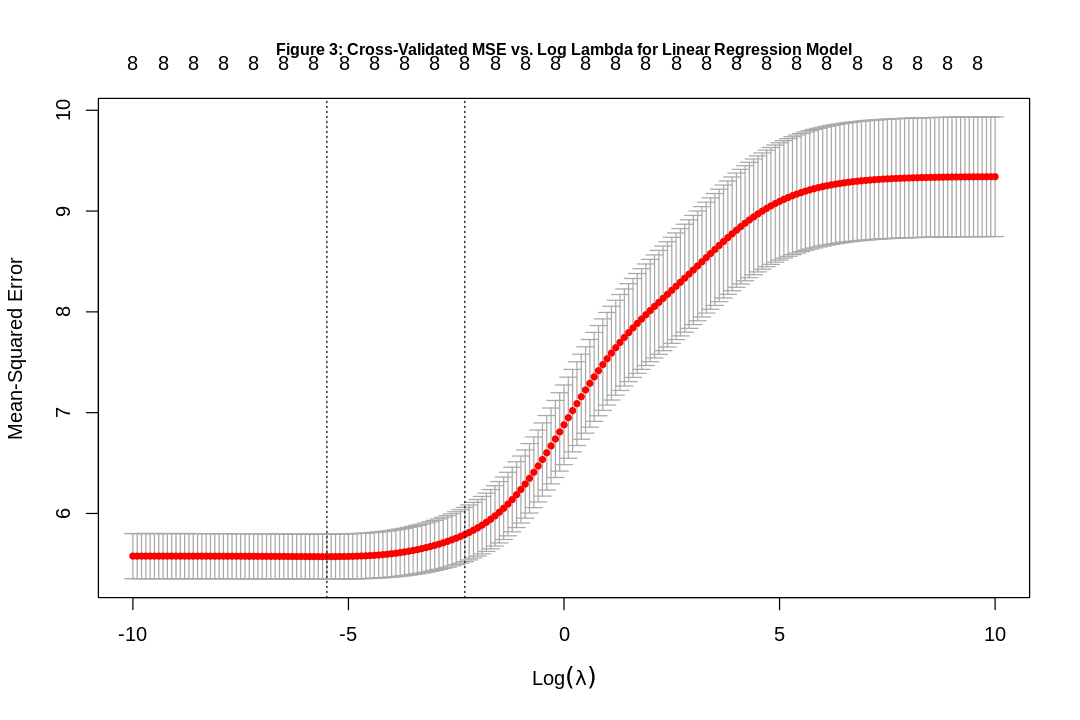

In [11]:
set.seed(2023)
abalone_cv_lambda_ridge_gaussian <- cv.glmnet(
  x = as.matrix(abalone_train_X), y = as.matrix(abalone_train_Y),
  alpha = 0, family = "gaussian", type.measure = "mse", nfolds = 10, lambda = exp(seq(-10, 10, 0.1)))
abalone_cv_lambda_ridge_gaussian
plot(abalone_cv_lambda_ridge_gaussian, main = "Figure 3: Cross-Validated MSE vs. Log Lambda for Linear Regression Model", cex.main = 0.8)

Obtain $\lambda_{min}$.

In [12]:
lambda_min_ridge_gaussian <- abalone_cv_lambda_ridge_gaussian$lambda.min
lambda_min_ridge_gaussian

[1] 0.004086771

Obtain the average cross-validation MSE and RMSE of the model `abalone_cv_lambda_ridge_gaussian` above with `lambda_min_ridge_gaussian` that minimizes the MSE, on the **training dataset**. The model **has not seen the testing set yet** at this stage.

In [13]:
abalone_rmse_result <- tibble(
    Model = c("Linear (Gaussian) Regression Model Using Ridge Algorithm with Lambda that Minimum MSE"), 
    CV_MSE_Training = c(abalone_cv_lambda_ridge_gaussian$cvm[which(abalone_cv_lambda_ridge_gaussian$lambda == 
                                                                   abalone_cv_lambda_ridge_gaussian$lambda.min)]),
    CV_RMSE_Training = c(sqrt(abalone_cv_lambda_ridge_gaussian$cvm[which(abalone_cv_lambda_ridge_gaussian$lambda == 
                                                                   abalone_cv_lambda_ridge_gaussian$lambda.min)])))
abalone_rmse_result

Model,CV_MSE_Training,CV_RMSE_Training
<chr>,<dbl>,<dbl>
Linear (Gaussian) Regression Model Using Ridge Algorithm with Lambda that Minimum MSE,5.571975,2.360503


Table 9

Then we fit the second model, the **Poisson regression model with Ridge algorithm**, that can better handle the dataset when the response variable (`Rings`) is actually discrete counts. The code is exactly the same as what we did above for `abalone_cv_lambda_ridge_gaussian`, except the `family` argument in the `cv.glmnet()` function should be "poisson". Again, we perform these only on the training set.


Call:  cv.glmnet(x = as.matrix(abalone_train_X), y = as.matrix(abalone_train_Y),      lambda = exp(seq(-10, 10, 0.1)), type.measure = "mse", nfolds = 10,      alpha = 0, family = "poisson") 

Measure: Mean-Squared Error 

    Lambda Index Measure     SE Nonzero
min 0.0101   147   5.726 0.2409       8
1se 0.3329   112   5.962 0.3074       8

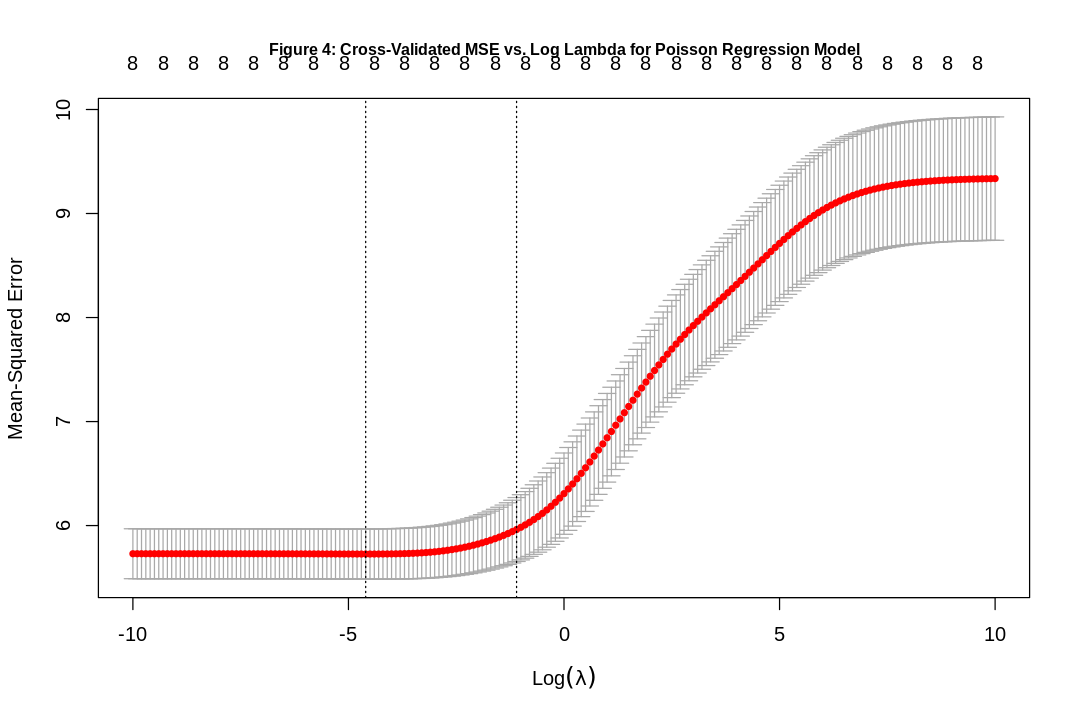

In [14]:
set.seed(2023)
abalone_cv_lambda_ridge_poisson <- cv.glmnet(
  x = as.matrix(abalone_train_X), y = as.matrix(abalone_train_Y),
  alpha = 0, family = "poisson",type.measure = "mse", nfolds = 10, lambda = exp(seq(-10, 10, 0.1)))
abalone_cv_lambda_ridge_poisson
plot(abalone_cv_lambda_ridge_poisson, main = "Figure 4: Cross-Validated MSE vs. Log Lambda for Poisson Regression Model", cex.main = 0.8)

Obtain the $\lambda_{min}$ for this Poisson regression model.

In [15]:
lambda_min_ridge_poisson <- abalone_cv_lambda_ridge_poisson$lambda.min
lambda_min_ridge_poisson

[1] 0.01005184

Add the average cross-validation MSE and RMSE of the model `abalone_cv_lambda_ridge_poisson` above with the corresponding `lambda_min_ridge_poisson` to the result table `abalone_rmse_result`. Again, this model **has not seen the testing set yet** at this stage, and is only evaluated on the **training dataset** by cross-validation.

In [16]:
abalone_rmse_result <- rbind(abalone_rmse_result,
                            tibble(Model = "Poisson Regression Model Using Ridge Algorithm with Lambda that Minimum MSE",
                                   CV_MSE_Training = abalone_cv_lambda_ridge_poisson$cvm[which(abalone_cv_lambda_ridge_poisson$lambda 
                                                                                          == abalone_cv_lambda_ridge_poisson$lambda.min)],
                                   CV_RMSE_Training = sqrt(abalone_cv_lambda_ridge_poisson$cvm[which(abalone_cv_lambda_ridge_poisson$lambda 
                                                                                          == abalone_cv_lambda_ridge_poisson$lambda.min)])))
abalone_rmse_result

Model,CV_MSE_Training,CV_RMSE_Training
<chr>,<dbl>,<dbl>
Linear (Gaussian) Regression Model Using Ridge Algorithm with Lambda that Minimum MSE,5.571975,2.360503
Poisson Regression Model Using Ridge Algorithm with Lambda that Minimum MSE,5.726223,2.392953


Table 10

From the table above, we observe that the **Linear (Gaussian) regression model** has a better performance than the **Poisson (Gaussian) regression model** because it has a lower average cross-validation Root Mean Square Error on the **training set**. Although this difference is so small that can even be neglected, we still pick the better model for prediction on the **testing set**. Add a new column called `Predicted_Rings` that stores the predicted values of `Rings` to `abalone_testing` dataset.

In [17]:
abalone_predicted_values_testing_set <- predict(abalone_cv_lambda_ridge_gaussian, newx = as.matrix(abalone_test_X), lambda_min_ridge_gaussian)

abalone_testing_prediction <- abalone_testing %>% mutate(Predicted_Rings = as.numeric(abalone_predicted_values_testing_set))
head(abalone_testing_prediction, 5)

Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Predicted_Rings
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Male,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,9.583382
Male,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.369014
Male,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,9.892915
Female,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20,13.624092
Female,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16,11.535380


Table 11

Now we compute the RMSE on the testing set to evaluate the performance of the **only one** selected predictive model from above.

In [18]:
abalone_rmse_result_testing <- tibble(
  Model = "Selected Traditional Linear (Gaussian) Regression Model Using Ridge Algorithm with Lambda that Minimum MSE",
  RMSE_Testing_Set = rmse(
    preds = abalone_testing_prediction$Predicted_Rings,
    actuals = abalone_testing_prediction$Rings
  )
)
abalone_rmse_result_testing

Model,RMSE_Testing_Set
<chr>,<dbl>
Selected Traditional Linear (Gaussian) Regression Model Using Ridge Algorithm with Lambda that Minimum MSE,2.445473


Table 12

The last step is to visualize the prediction by constructing a prediction vs actual scatter plot. For a perfect predictive model, dots should lie on the line $y=x$; therefore, we expect that the dots should not diverge too much from $y=x$ for a acceptable predictive model.

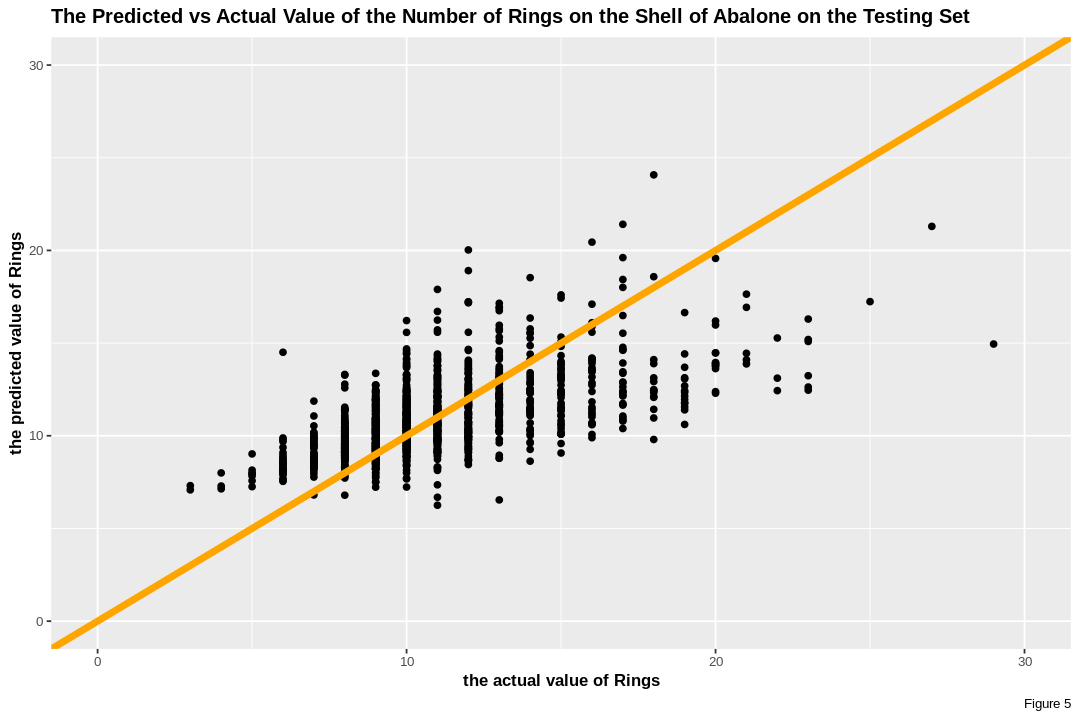

In [19]:
testing_pred_vs_actual_scatterplot <- ggplot(abalone_testing_prediction, aes(x = Rings, y = Predicted_Rings)) +
  geom_point() +
  geom_abline(intercept=0,slope=1, linewidth=2, col = "orange")+
  xlab('the actual value of Rings') +
  ylab('the predicted value of Rings') +
  xlim(0,30)+
  ylim(0,30)+
  ggtitle('The Predicted vs Actual Value of the Number of Rings on the Shell of Abalone on the Testing Set')+
  labs(caption="Figure 5")+
  theme(
    text = element_text(size = 10),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  )
testing_pred_vs_actual_scatterplot

## **Discussion:**
### Summary of Findings and Implications:
The average CV-RMSEs on the training set of the traditional linear regression model and the Poisson regression model (both fitted by Ridge algorithm) are approximately 2.36 and 2.39 respectively. The model with the lower CV-RMSE is chosen for prediction on the testing set, where the selected **linear regression model** yields a testing RMSE of 2.45. Considering the range of the response variable `Rings` is from 1 to 29, the chosen model demonstrated a commendable level of accuracy with the residuals having a standard deviation of less than 2.5. From *Figure 5*, we observe that the selected model tends to over-predict when the actual value is less than 10, while under-predict for actual `Rings` greater than 15. The study also underscores the importance of addressing multicollinearity and the effectiveness of Ridge algorithm in such scenarios. The model provides a tool for quickly predicting the age (number of rings on the shell) of abalone, aiding in sustainable fishing practices. Similar to regulations in lobster fishing, this could inform guidelines for abalone harvesting, ensuring younger specimens are returned to the ocean to maintain ecological balance.

### Unexpectation From the Result:
- The regularized method **Ridge algorithm** are used to address multicollinearity in both fitted models, but the penalty parameters $\lambda_{min}$ in both models are very small, making the models mathematically more stable and robust but intuitively not much different from models fitted by non-regularized method like least squares.
- We expected that the Poisson regression model would be more suitable for this dataset as the response variable recorded as discrete counts. However, the CV-RMSE indicates that the Poisson regression model does not outperform and even has a slightly higher CV-RMSE than the linear regression model, making the traditional linear mechanism robust enough for this data, and our initial assumption of treating the response `Rings` as continuous is practically reasonable.

### Model Improvement:
- **Non-Linear Models:** Investigating non-linear models could uncover patterns not discernible in the current framework. We assume linearity in the models, but we can improve the model by testing if a curve fitting or polynomial transformation on input variables is necessary.
- **Interaction Analysis:** Incorporating interaction terms might reveal hidden relationships between physical measurements, enhancing the model's predictive power.

### Future Questions/Research:
- **Environmental Factor Integration:** Including environmental variables such as water temperature or habitat conditions could improve the model's performance and relevance.
- **Machine Learning Approaches:** Exploring advanced machine learning techniques might offer more sophisticated insights, especially in handling non-linear relationships and complex data structures.

## **References:**

* [1] Nash, W., Sellers, T., Talbot, S., Cawthorn, A., & Ford, W. *Abalone*. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Abalone 
* [2] Roback, P., &amp; Legler, J. M. (2021). *Beyond multiple linear regression: Applied generalized linear models and multilevel models in R*. CRC Press. 
* [3] James, G., Witten, D., Hastie, T., &amp; Tibshirani, R. (2013). *An introduction to statistical learning: With applications in R*. New York : Springer.
* [4] Jenkins, G. P. (2004, September 16). The ecosystem effects of Abalone Fishing: A Review. CSIRO PUBLISHING. https://www.publish.csiro.au/mf/MF04046 